<a href="https://colab.research.google.com/github/eTroupe5201/SE489_Group_Project/blob/main/Model_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install hugging face dataset, accelerate and transformers library

In [11]:
%pip install --upgrade datasets
print("Downloading datasets...")
%pip install transformers -U
print("Downloading transformers...")
%pip install accelerate -U
print("Downloading accelerate...")
%pip install --upgrade matplotlib 
%pip install --upgrade seaborn

print("Downloading plotting libraries...")
%pip install --upgrade dill

print("Downloading dill...")
print("Completed!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/300.2 kB 495.5 kB/s eta 0:00:01
   -------------------- ------------------- 153.6/300.2 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Completed!


Import rotten tomatoes dataset from huggingface. Data is automatially split for training, validation, and testing.

*   Training split: 8530 examples
*   Validation split: 1066 examples
*   Test split: The remaining examples



In [23]:
from datasets import load_dataset
print("Loading training dataset... ")
# Load the dataset
training_dataset = load_dataset("imdb", split="train")

print("Loading validation dataset... ")
# Access the validation split
unsupervised_dataset = load_dataset("imdb", split="unsupervised")

print("Loading test dataset... ")
# Access the validation split
test_dataset = load_dataset("imdb", split="test")



Loading training dataset... 
Loading validation dataset... 
Loading test dataset... 


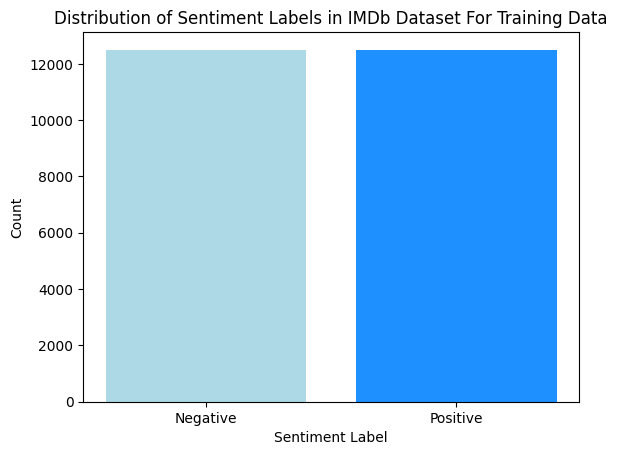

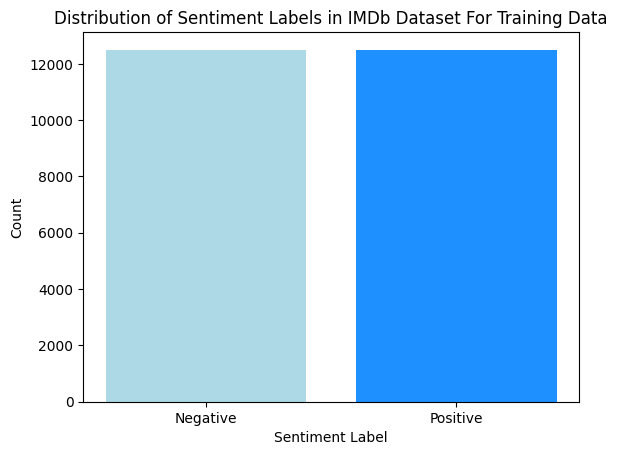

In [33]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("imdb")

# Example code for visualizations
# 1. Distribution of Sentiment Labels
sentiments = dataset['train']['label']

sentiment_counts = {0: 0, 1: 0}  
for sentiment in sentiments:
    sentiment_counts[sentiment] += 1

# Plot the distribution of sentiment labels
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['#ADD8E6', '#1E90FF'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels in IMDb Dataset For Training Data')
plt.xticks(list(sentiment_counts.keys()), ['Negative', 'Positive'])  # Replace labels with descriptive names if needed
plt.show()

sentiments = dataset['test']['label']
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['#ADD8E6', '#1E90FF'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels in IMDb Dataset For Training Data')
plt.xticks(list(sentiment_counts.keys()), ['Negative', 'Positive'])  # Replace labels with descriptive names if needed
plt.show()





Initialize tokenizer and model. Utilizing Distilbert model from hugging face and a pre-trained tokenizer. This model has been fine-tuned on the Stanford Sentiment Treebank dataset.

In [3]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


c:\Users\etrou\anaconda3\envs\sentiment_analysis\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\etrou\anaconda3\envs\sentiment_analysis\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\etrou\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need 

Import pytorch library, training arguments and dataloader
#Define Training Arguments:

*   Learning rate hyperparmeter: is set to 2e-5. It controls how much we are adjusting the model parameters during training.
*   Epochs: set to 1.This is the number of training epochs. It specifies how many times the entire dataset will be passed through.
*   Batch Size: is set to 32. It determines the number of samples processed in each iteraion during training.



In [14]:
import torch
from torch.utils.data import DataLoader

from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./output',                    # Specify the output directory
    per_device_train_batch_size=64,           # Batch size per GPU during training
    num_train_epochs=1,                       # Number of training epochs
    logging_dir='./logs',                     # Directory for logging training metrics
    logging_steps=500,                        # Interval for logging training metrics
    save_steps=1000,                          # Interval for saving model checkpoints
    evaluation_strategy="epoch",              # Evaluation strategy (perform evaluation after each epoch)
    learning_rate=2e-5,                       # Learning rate
)

# You can access the training parameters like this:
learning_rate = training_args.learning_rate
num_epochs = training_args.num_train_epochs
batch_size = training_args.per_device_train_batch_size



In [5]:
# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


#PREPROCESS DATA


*   Tokenize Data: tokenize entire dataset
*   Padding: set to true, ensures that sequences have the same length
* Truncating: ensures that sequences are not longer than the maximum length allowed.


Convert label data into Pytourch tensors

Create Pytorch Dataloader


Training Dataset

In [6]:

# Tokenize and pad the entire dataset
tokenized_dataset = tokenizer(training_dataset['text'], padding=True, truncation=True, return_tensors='pt')

# Convert labels to tensors
labels = torch.tensor(training_dataset['label'])

# Create DataLoader with aligned batch sizes
dataloader = DataLoader(list(zip(tokenized_dataset['input_ids'], tokenized_dataset['attention_mask'], labels)), batch_size=batch_size, shuffle=True)


Validation Dataset

In [7]:

# Tokenize and pad the entire validation dataset
tokenized_validation_dataset = tokenizer(validation_dataset['text'], padding=True, truncation=True, return_tensors='pt')

# Convert validation labels to tensors
validation_labels = torch.tensor(validation_dataset['label'])

# Create DataLoader for validation dataset with aligned batch sizes
validation_dataloader = DataLoader(
    list(zip(tokenized_validation_dataset['input_ids'], tokenized_validation_dataset['attention_mask'], validation_labels)),
    batch_size=batch_size,
    shuffle=False
)


Test Dataset

In [8]:
# Tokenize and pad the entire test dataset
tokenized_test_dataset = tokenizer(test_dataset['text'], padding=True, truncation=True, return_tensors='pt')

# Convert test labels to tensors
test_labels = torch.tensor(test_dataset['label'])

# Create DataLoader for test dataset with aligned batch sizes
test_dataloader = DataLoader(
    list(zip(tokenized_test_dataset['input_ids'], tokenized_test_dataset['attention_mask'], test_labels)),
    batch_size=batch_size,
    shuffle=False  # No need to shuffle test data
)


In [9]:
import pickle

# Save tokenized datasets
with open('tokenized_training_dataset.pkl', 'wb') as f:
    pickle.dump(tokenized_dataset, f)

with open('tokenized_validation_dataset.pkl', 'wb') as f:
    pickle.dump(tokenized_validation_dataset, f)

with open('tokenized_test_dataset.pkl', 'wb') as f:
    pickle.dump(tokenized_test_dataset, f)

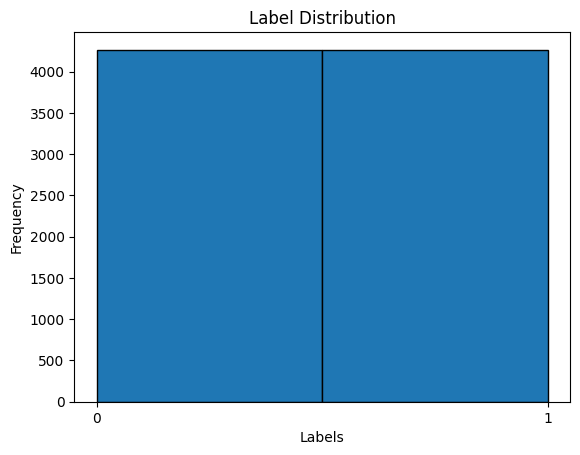

In [10]:
import matplotlib.pyplot as plt

# Plot label distribution
plt.hist(training_dataset['label'], bins=2, edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.xticks([0, 1])
plt.show()

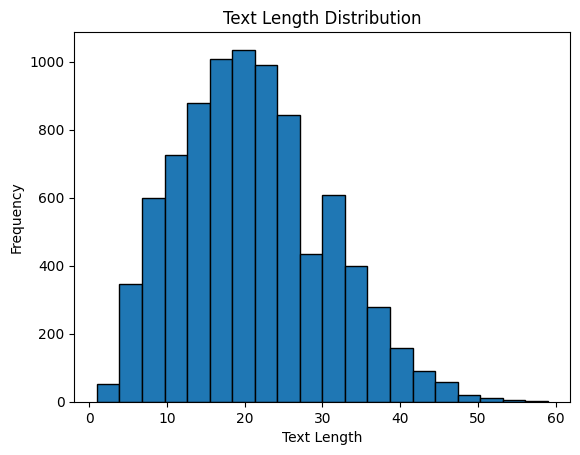

In [11]:
# Calculate text lengths
text_lengths = [len(text.split()) for text in training_dataset['text']]

# Plot text length distribution
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()


#PREDICTIONS
It is considered good practice predict outcomes before training the model.

torch.no_grad: disables gradient calculation. This speeds up computation and reduces memory consumption.

We unpack the dictionary and compute the output.

logits: raw scores for each class in the classfication task.

torch.argmax(outputs.logits, dim=1) find the index of hte class with the highest confidence socre and specified dimension.

Predictions: contains the predicted class labels for the input samples based on the model's output logits.


In [12]:
import torch

# Define the mapping between class indices and sentiment labels
#sentiment_mapping = {0: "Negative", 1: "Positive"}

# Initialize a list to store all predictions
all_predictions = []

# Iterate over your dataset in batches
for batch_start in range(0, len(tokenized_test_dataset["input_ids"]), batch_size):
    # Get the current batch
    batch_end = min(batch_start + batch_size, len(tokenized_test_dataset["input_ids"]))
    batch_input_ids = tokenized_test_dataset["input_ids"][batch_start:batch_end]
    batch_attention_mask = tokenized_test_dataset["attention_mask"][batch_start:batch_end]

    # Pass the tokenized text through the model
    with torch.no_grad():
        batch_outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)

    # Interpret the outputs
    batch_predictions = torch.argmax(batch_outputs.logits, dim=1)

    # Append batch predictions to the list
    all_predictions.extend(batch_predictions.tolist())

    # Print progress
    print(f"Processed batch {batch_start // batch_size + 1}/{len(tokenized_test_dataset['input_ids']) // batch_size}")

    # Clear variables to free up memory
    del batch_input_ids, batch_attention_mask, batch_outputs

# Convert the list of predictions to a tensor
all_predictions_tensor = torch.tensor(all_predictions)

# Save all predictions to a file
torch.save(all_predictions_tensor, 'predictions.pt')

print("All predictions saved to 'predictions.pt'")
#save tensor to file


Processed batch 1/66
Processed batch 2/66
Processed batch 3/66
Processed batch 4/66
Processed batch 5/66
Processed batch 6/66
Processed batch 7/66
Processed batch 8/66
Processed batch 9/66
Processed batch 10/66
Processed batch 11/66
Processed batch 12/66
Processed batch 13/66
Processed batch 14/66
Processed batch 15/66
Processed batch 16/66
Processed batch 17/66
Processed batch 18/66
Processed batch 19/66
Processed batch 20/66
Processed batch 21/66
Processed batch 22/66
Processed batch 23/66
Processed batch 24/66
Processed batch 25/66
Processed batch 26/66
Processed batch 27/66
Processed batch 28/66
Processed batch 29/66
Processed batch 30/66
Processed batch 31/66
Processed batch 32/66
Processed batch 33/66
Processed batch 34/66
Processed batch 35/66
Processed batch 36/66
Processed batch 37/66
Processed batch 38/66
Processed batch 39/66
Processed batch 40/66
Processed batch 41/66
Processed batch 42/66
Processed batch 43/66
Processed batch 44/66
Processed batch 45/66
Processed batch 46/

In [15]:
import torch.nn as nn

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()
# Define the print frequency
print_freq = 10  # Print loss every 10 batches

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Set model to training mode
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, batch in enumerate(dataloader):
        input_ids, attention_mask, batch_labels = batch

        optimizer.zero_grad()

        # Forward pass: compute predicted outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = criterion(logits, batch_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update statistics
        running_loss += loss.item() * input_ids.size(0)
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

        if (batch_idx + 1) % print_freq == 0:
            print(f'Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions

    print(f'Epoch {epoch + 1} completed, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')



Epoch 1/1
----------
Batch 10/534, Loss: 0.1942
Batch 20/534, Loss: 0.6877
Batch 30/534, Loss: 0.1614
Batch 40/534, Loss: 0.0048
Batch 50/534, Loss: 0.5121
Batch 60/534, Loss: 0.7961
Batch 70/534, Loss: 0.5829
Batch 80/534, Loss: 0.3672
Batch 90/534, Loss: 0.2574
Batch 100/534, Loss: 0.3252
Batch 110/534, Loss: 0.3419
Batch 120/534, Loss: 0.2966
Batch 130/534, Loss: 0.3904
Batch 140/534, Loss: 0.0072
Batch 150/534, Loss: 1.1998
Batch 160/534, Loss: 0.4755
Batch 170/534, Loss: 0.6694
Batch 180/534, Loss: 0.2286
Batch 190/534, Loss: 0.8729
Batch 200/534, Loss: 0.6883
Batch 210/534, Loss: 1.2530
Batch 220/534, Loss: 0.0020
Batch 230/534, Loss: 0.0087
Batch 240/534, Loss: 1.9703
Batch 250/534, Loss: 0.9261
Batch 260/534, Loss: 0.7979
Batch 270/534, Loss: 0.9404
Batch 280/534, Loss: 0.8684
Batch 290/534, Loss: 0.9273
Batch 300/534, Loss: 0.2921
Batch 310/534, Loss: 0.8636
Batch 320/534, Loss: 0.3967
Batch 330/534, Loss: 0.4585
Batch 340/534, Loss: 0.0010
Batch 350/534, Loss: 0.4396
Batch 36

In [1]:
# Pickle the trained model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

NameError: name 'pickle' is not defined

In [ ]:
from torch.utils.data import DataLoader
#data loader for validation set

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Validation loop
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():  # No need to compute gradients during validation
    for batch in validation_dataloader:
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True)
        labels = batch['label']

        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Validation Accuracy: {accuracy}")


Validation Accuracy: 0.9015009380863039


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Test loop
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
with torch.no_grad():  # No need to compute gradients during testing
    for batch in test_dataloader:
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True)
        labels = batch['label']

        outputs = model(**inputs)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8968105065666041


Write a brief project description, including:
A. The overall goal of the project.

*   To develop a machine learning model for sentiment analysis on movie reviews, with the aim of accurately classifying each review as either positive or negative. By leveraging pre-trained models and fine-tuning techniques, the overall goal is to create a reliable classifier that effectively analyzes large volumes of text data.

B. The framework you plan to use, and how you intend to incorporate it into your project.

*   PyTorch: transformers
*   HuggingFace: Model, Dataset
*   Google Colab
*   TensorFlow


C. The data you initially plan to use (this may change).

*   Hugging Face Dataset: Rotten Tomatoes

D. The models you expect to use.

*   DistilBertForSequenceClassification

